# 16-13. 프로젝트 : Segmentation map으로 도로 이미지 만들기

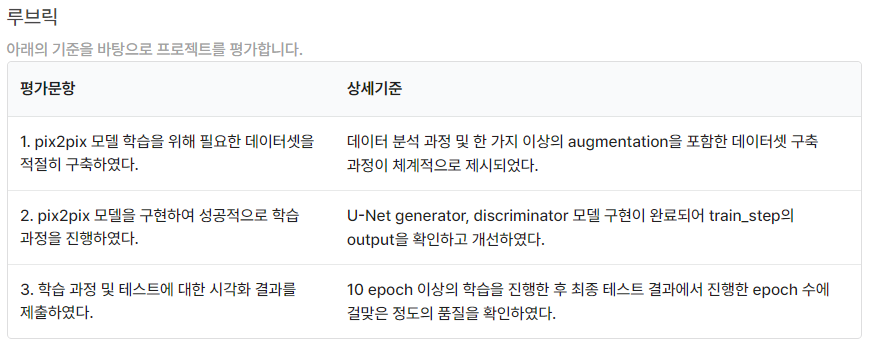

이전 Pix2Pix 논문에서 제시한 결과 중에 아래와 같은 실험 결과가 있었습니다. 도로의 레이블 정보를 활용해 이미지를 생성해낸 결과입니다.

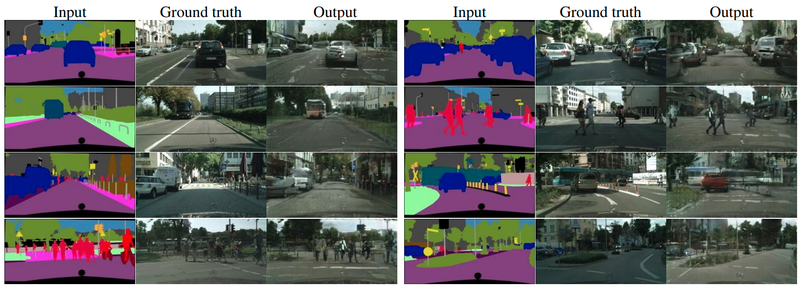

이번 프로젝트는 위와 같은 데이터셋을 이용해 Pix2Pix를 학습시켜보는 것입니다. 데이터셋은 아래에서 다운로드할 수 있습니다.
1000개의 학습용 이미지 및 5개의 평가 이미지를 포함합니다.

- [cityscapes.zip](https://d3s0tskafalll9.cloudfront.net/media/documents/cityscapes.zip)

이전 포켓몬 데이터에서 사용했던 스케치와는 조금 다른 레이블 정보 이미지를 입력으로 사용하기 때문에, 전처리 과정에 대해 약간의 혼란이 있을 수 있지만 크게 다른 과정은 없습니다.  
아래 Tensroflow에서 제공하는 Pix2Pix 튜토리얼은 위 이미지와 비슷한 레이블 정보 이미지를 사용하기 때문에 좋은 참고 자료가 될 수 있을 것 같습니다.  

프로젝트 시작에 어려움이 있다면 아래 튜토리얼을 참고하시면서 이번 프로젝트를 수행해 봅시다.  
(아래 튜토리얼은 Pix2Pix 구조를 Functional API를 이용해 구현하기 때문에 이번에 진행한 Subclassing 방법을 이용한 모델 구현과 비교하면서 구현 방법에 대해서도 공부해 보시길 추천드립니다)  

- [Tensorflow Pix2Pix Tutorial](https://www.tensorflow.org/tutorials/generative/pix2pix?hl=ko)


프로젝트를 수행하기 전에 주요 라이브러리 버전을 살펴 봅시다.

In [1]:
import numpy
import tensorflow

print(numpy.__version__)
print(tensorflow.__version__)

1.19.5
2.6.0


### 프로젝트 수행
----
프로젝트를 진행하면서 필수로 수행해야 할 사항은 다음과 같습니다.

1. 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해 주세요.
    (어떠한 방법을 사용했는지 적어주세요.)
    
    
2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해 주세요.



3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운로드했던 "val" 폴더 내 이미지를 사용해 주세요.


4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.


5. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

### 1. 데이터 준비하기

In [2]:
import os

data_path = './data/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


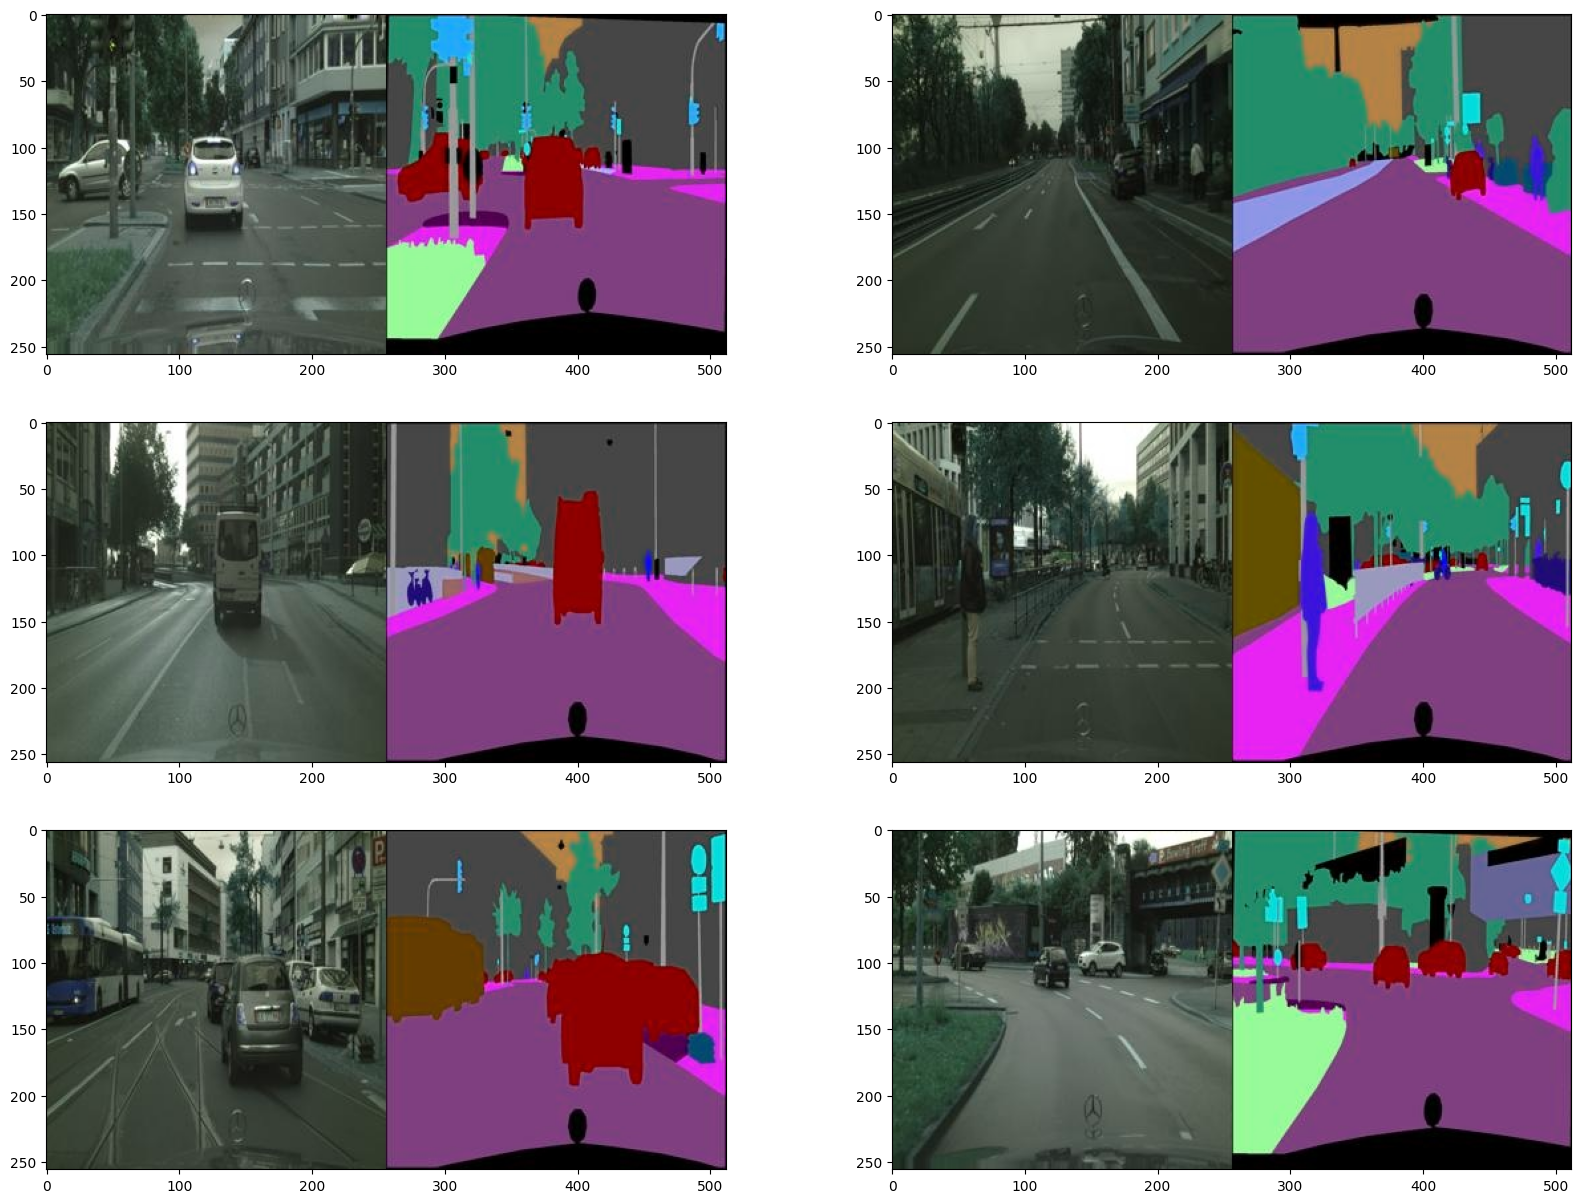

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [4]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


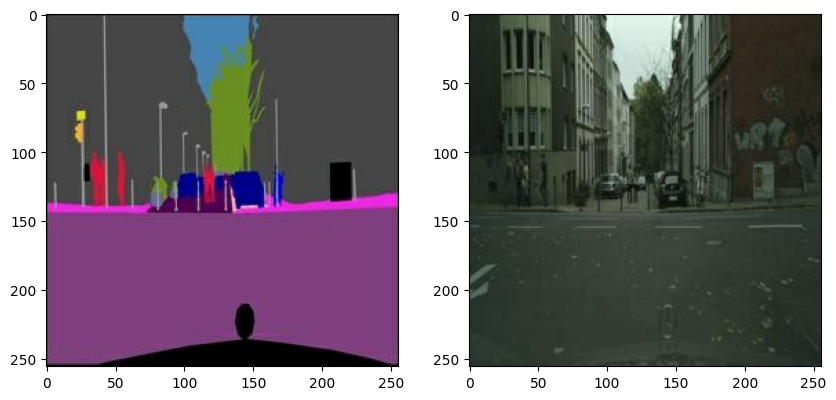

In [5]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    label = img[:, :w, :] 
    label = tf.cast(label, tf.float32)
    segmentation = img[:, w:, :] 
    segmentation = tf.cast(segmentation, tf.float32)
    return normalize(segmentation), normalize(label)

f = data_path + os.listdir(data_path)[1]
segmentation, label = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(segmentation))
plt.subplot(1,2,2); plt.imshow(denormalize(label))

### 2. 데이터 augmentation

In [6]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(segmentation, label):
    stacked = tf.concat([segmentation, label], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


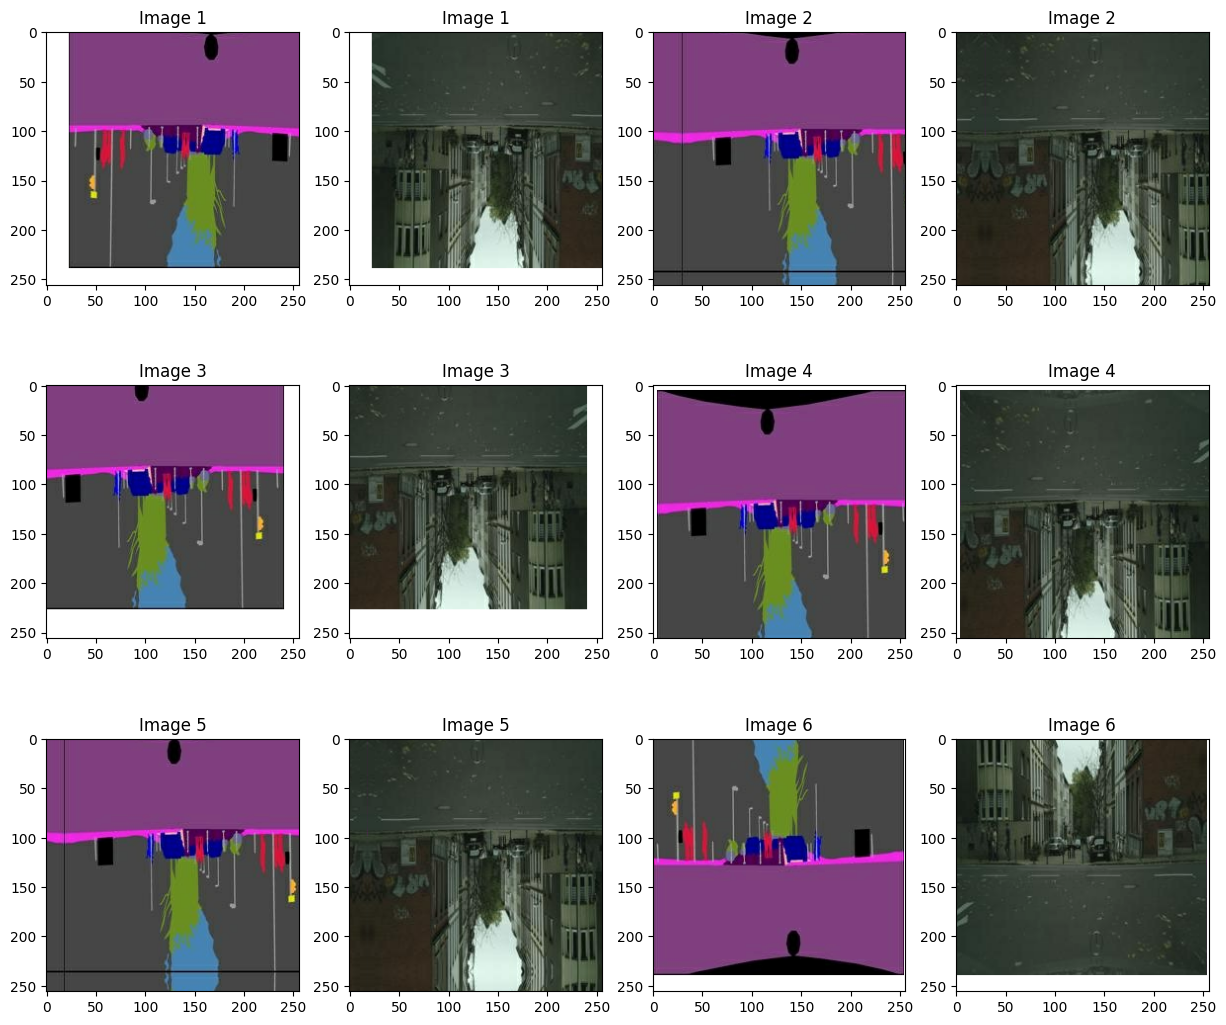

In [7]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_segmentation, augmented_label = apply_augmentation(segmentation, label)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_segmentation)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_label)); plt.title(f"Image {img_n}")
    img_n += 1

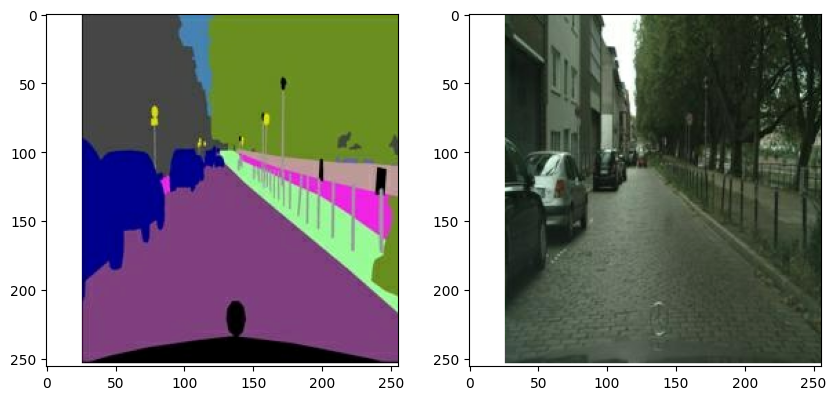

In [8]:
from tensorflow import data

#segmentation, label

def get_train(img_path):
    segmentation, label = load_img(img_path)
    segmentation, label = apply_augmentation(segmentation, label)
    return segmentation, label

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
segmentation, label = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(segmentation[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(label[0].astype(np.uint8))

#### data augmetation 목록

1. 두 이미지가 채널 축으로 연결됩니다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 됩니다.  
2. 1의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용됩니다. (tf.pad)  
3. 2의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다. (tf.image.random_crop)  
4. 3의 결과를 50% 확률로 가로로 뒤집습니다. (tf.image.random_flip_left_right)  
5. 4의 결과를 50% 확률로 세로로 뒤집습니다. (tf.image.random_flip_up_down)  
6. 5의 결과를 50% 확률로 회전시킵니다. (tf.image.rot90)  

In [9]:
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import optimizers, losses

### 3. Generator 구현

In [10]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [11]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [12]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

### 4. Discriminator 구현

In [13]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [14]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [15]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

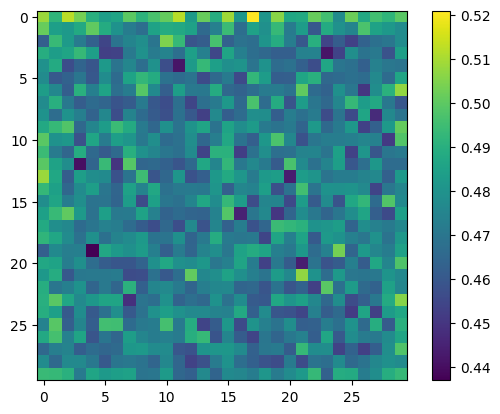

In [16]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

### 5. 학습

#### 1)손실함수 설정

In [17]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


#### 2) 옵티마이저 설정

In [18]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


#### 3) 학습 구현

In [19]:
#segmentation, label

@tf.function
def train_step(segmentation, label):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(segmentation, training=True)
        # Discriminator 예측
        fake_disc = discriminator(segmentation, fake_colored, training=True)
        real_disc = discriminator(segmentation, label, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, label, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [20]:
EPOCHS = 600

generator = UNetGenerator()
discriminator = Discriminator()

g_loss_his = []
l1_loss_his = []
d_loss_his = []

for epoch in range(1, EPOCHS+1):
    for i, (segmentation, label) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(segmentation, label)           
        
    if epoch % 10 == 0:
        print(f"EPOCH[{epoch}] \
          \nGenerator_loss:{g_loss.numpy():.4f} \
          \nL1_loss:{l1_loss.numpy():.4f} \
          \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")
        
        g_loss_his.append(g_loss.numpy())
        l1_loss_his.append(l1_loss.numpy())
        d_loss_his.append(d_loss.numpy())

EPOCH[10]           
Generator_loss:0.3110           
L1_loss:0.2199           
Discriminator_loss:1.6454

EPOCH[20]           
Generator_loss:2.1953           
L1_loss:0.1981           
Discriminator_loss:0.3006

EPOCH[30]           
Generator_loss:1.2218           
L1_loss:0.1686           
Discriminator_loss:0.9081

EPOCH[40]           
Generator_loss:0.8067           
L1_loss:0.1464           
Discriminator_loss:0.8784

EPOCH[50]           
Generator_loss:1.1000           
L1_loss:0.1869           
Discriminator_loss:0.7181

EPOCH[60]           
Generator_loss:1.4040           
L1_loss:0.1844           
Discriminator_loss:0.4766

EPOCH[70]           
Generator_loss:1.2963           
L1_loss:0.1770           
Discriminator_loss:0.5169

EPOCH[80]           
Generator_loss:0.8692           
L1_loss:0.2053           
Discriminator_loss:0.6320

EPOCH[90]           
Generator_loss:1.4508           
L1_loss:0.1820           
Discriminator_loss:0.3404

EPOCH[100]           
Generator_loss:

#### 4) 학습결과 각 loss 시각화

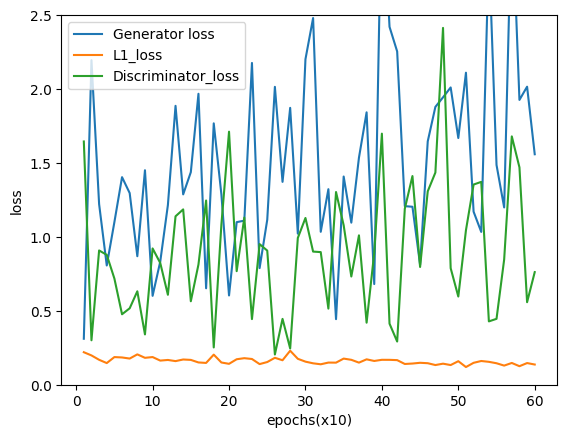

In [38]:
x = list(range(1, 61))

plt.plot(x, g_loss_his, label='Generator loss')
plt.plot(x, l1_loss_his, label='L1_loss')
plt.plot(x, d_loss_his, label='Discriminator_loss')
plt.xlabel('epochs(x10)')
plt.ylabel('loss')
plt.ylim(0, 2.5)
plt.legend()

### 6. 테스트

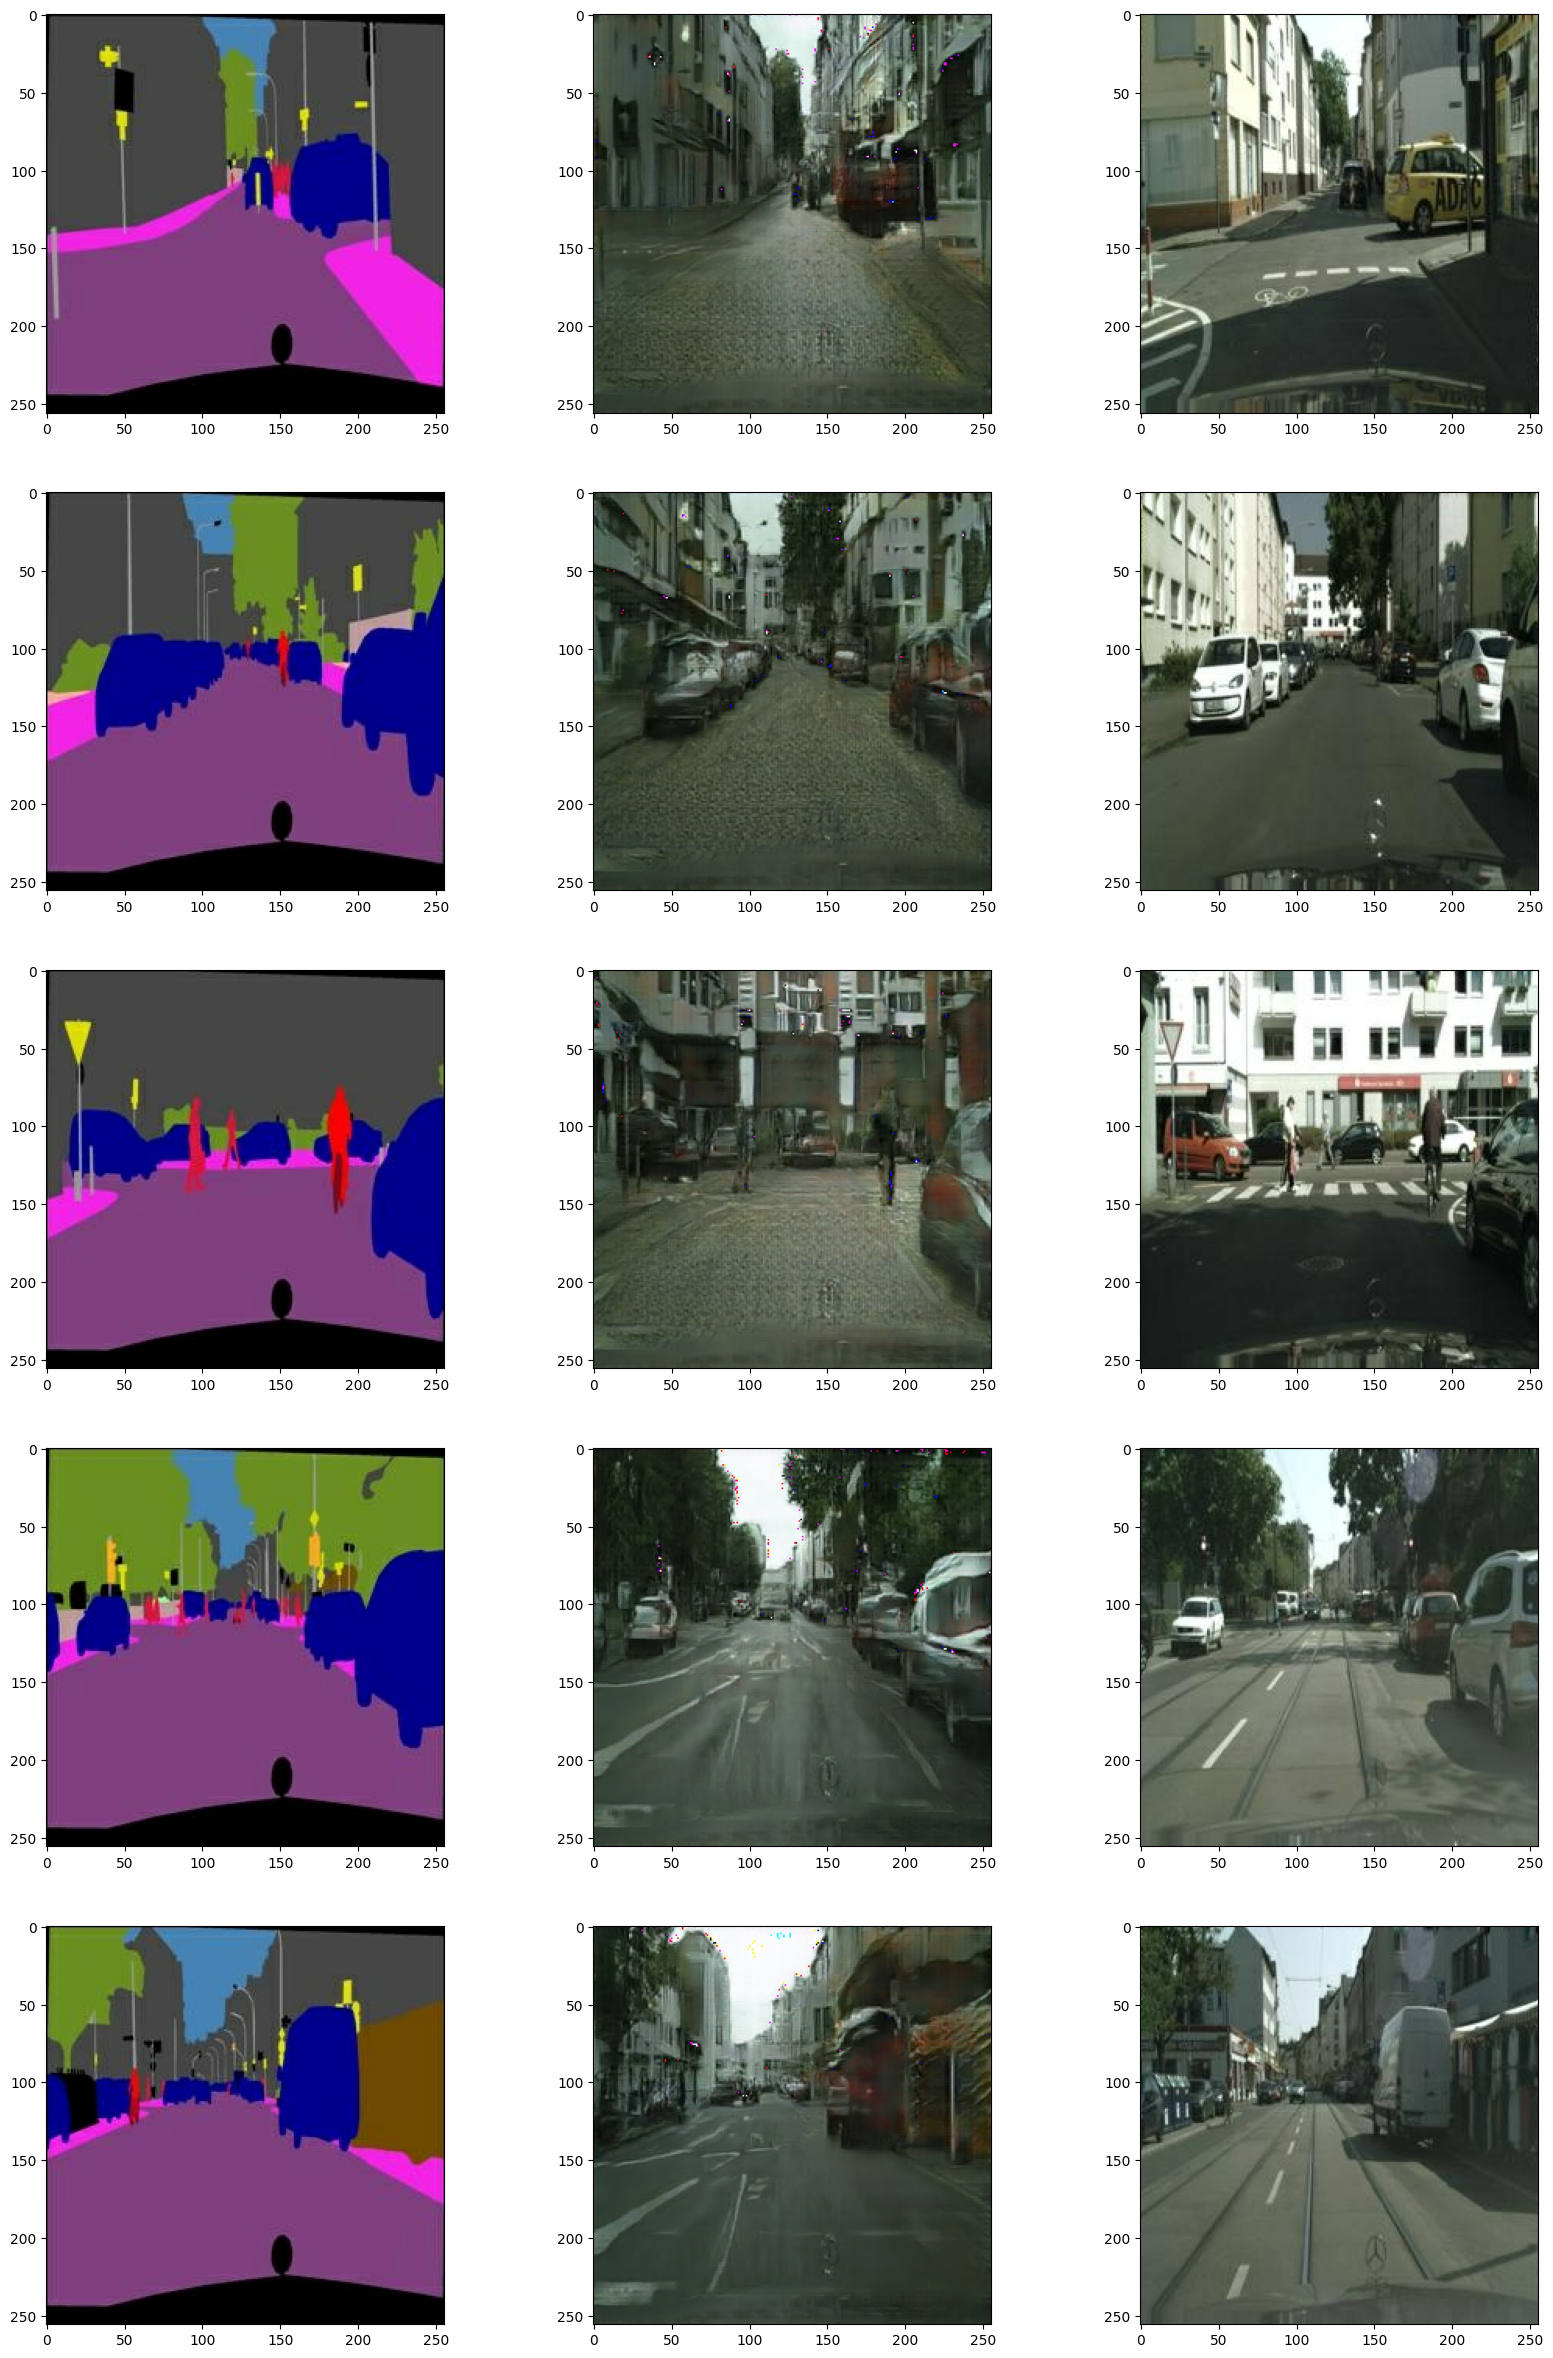

In [22]:
test_data_path = './data/val/'

for i in range(len(os.listdir(test_data_path))):
    f = test_data_path + os.listdir(test_data_path)[i]
    globals()[f'segmentation{i}'], globals()[f'label{i}'] = load_img(f)
    globals()[f'pred{i}'] = generator(tf.expand_dims(globals()[f'segmentation{i}'], 0))
    globals()[f'pred{i}'] = denormalize(globals()[f'pred{i}'])

plt.figure(figsize=(20,30))
for i in range(1, len(os.listdir(test_data_path)) + 1):
    plt.subplot(5,3,(i * 3) - 2); plt.imshow(denormalize(globals()[f'segmentation{i - 1}']))
    plt.subplot(5,3,(i * 3) - 1); plt.imshow(globals()[f'pred{i - 1}'][0])
    plt.subplot(5,3,(i * 3)); plt.imshow(denormalize(globals()[f'label{i - 1}']))

# 회고

<br/>

### 신경쓴점
- 시각화에 신경썼다. 
- 최대한 많은 epcoh을 돌려서 모델 성능을 끌어올렸다. 


### 아쉬운점
- 모델의 구조에 대해 아직 제대로 이해하지 못했다. 
- 파이썬 문법중 이해되지 않는 부분이 나타나기 시작했다. 
- 각 loss값을 통해 모델이 개선여지가 있는지 알아내지 못했다. 


### 개선해야할점
- 좀더 파이썬 문법에 신경써야 할것 같다. 


### referance
- LMS